In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Fei Tian Middletown /Fall 2022/ML & AI/Final Project/src

/content/drive/MyDrive/Fei Tian Middletown /Fall 2022/ML & AI/Final Project/src


In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


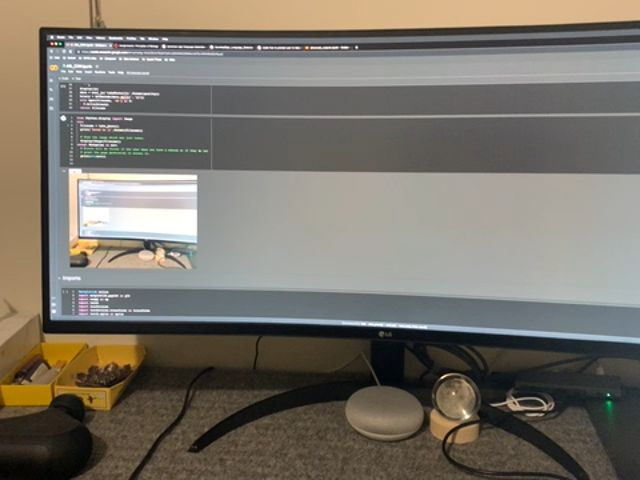

In [3]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

  

# Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from general import GeneralUtil as util

# Train Image Classifier CNN

## 1. Load Data

In [ ]:
TRAINING_PATH = '../images/training'
TESTING_PATH = '../images/testing'

In [ ]:
# Set the batch size
batch_size = 5
# Set the classes
classes = ('A', 'B', 'C', 'D', 'E')

# Set up transformer to normalize the data
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        # https://pytorch.org/vision/main/auto_examples/plot_transforms.html#randomresizedcrop
        # transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), 
        #         ratio=(0.9, 1.1)),
        # https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Create the training and test datasets as well as the data loaders
trainset = datasets.ImageFolder(TRAINING_PATH, transform=train_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.ImageFolder(TESTING_PATH, transform=test_transform)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
util.print("Successfully loaded images", color='green')


Successfully loaded images


Let's visualize some of the images in the dataset.

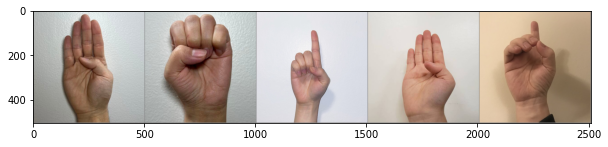

           B            E            D            B            D


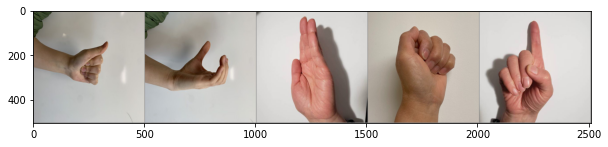

           A            C            B            E            D


In [ ]:
def display_sample_image(imageloader, n=1):
  plt.rcParams["figure.figsize"] = (10, 10)
  def _imshow(img):
      img = img / 2 + 0.5     # unnormalize
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()

  for _ in range(n):
    # get some random images
    dataiter = iter(imageloader)
    images, labels = next(dataiter)

    # show images
    _imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%12s' % classes[labels[j]] for j in range(batch_size)))

display_sample_image(train_loader, n=2)


## 2. Build CNN Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # in_channels, out_channels, kernel_size
        self.conv1 = nn.Conv2d(3, 6, 5)
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # think out_channels as a number of feature detectors, we have 6 detectors here

        self.pool = nn.MaxPool2d(2, 2)  # kernel_size
        # https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

        # in_channels, out_channels, kernel_size
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # in_features, out_features
        self.fc2 = nn.Linear(120, 84)  # in_features, out_features
        self.fc3 = nn.Linear(84, 10)  # in_features, out_features

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # tart_dim=1, flatten all dimensions except batch
        x = torch.flatten(x, 1)
        # https://pytorch.org/docs/stable/generated/torch.flatten.html

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
class ASL_CNN(nn.Module):
    def __init__(self, num_classes: int = 5, 
                 dropout: float = 0.5) -> None:
        super().__init__()
        
        self.features = nn.Sequential(
            # Conv1 https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Conv2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), #  15x15

            # Conv3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), #  7x7

            # Conv4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Conv5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3)) 
        # average pooling, just specify output size
        # https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html


        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout), # p = dropout probability
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes), 
        )

        # initialize the weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Based on our previous discussion, we should initialize the convolutions according to the activation function
                # Fan-out focuses on the gradient distribution, 
                # and is commonly used
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## 3. Define Loss Function and Optimizer

Let's use cross entropy loss and Adam optimizer.

In [ ]:
net = ASL_CNN(num_classes=5, dropout=0.5)

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Adam optimizer
# optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the CNN

In [ ]:
torch.device("cuda")

device(type='cuda')

In [ ]:
def train(device=torch.device("cpu"), scheduler=None):
    util.print('Training Initializing', header=True, color='cyan')
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    return running_loss

In [ ]:
training_loss = []
for epoch in range(5):  # loop over the dataset multiple times
    training_loss.append(train())
    # train()
util.print('Finished Training', color='green')

# ---------------------
# Training Initializing
# ---------------------


RuntimeError: ignored

In [ ]:
def validation(testdata_loader, device=torch.device("cpu")):
    correct = 0
    total = 0
    net.eval()

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}


    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testdata_loader:
            images, labels = data
            # calculate outputs by running images through the network 
            outputs = net(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data.detach().cpu(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    print("=="*30)
    print(f'Accuracy of the network on the test images: {100 * correct / total}%')
    print("=="*30)
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

In [ ]:
validation(testloader)

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

def _imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print images
_imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \n', ' '.join( (("\n"*(j % 8== 0))+ '%5s') % classes[labels[j]] 
        for j in range(batch_size)))

### 4.2 Save the Trained Model

In [ ]:
PATH = '../models/asl_cnn.pth'
torch.save(net.state_dict(), PATH)